In [17]:
import pandas as pd
import numpy as np

In [18]:
df_clean = pd.read_csv('anime_data_clean.csv')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9714 entries, 0 to 9713
Data columns (total 82 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title_english            9714 non-null   object 
 1   status                   9714 non-null   int64  
 2   episodes                 9714 non-null   float64
 3   rating                   9714 non-null   object 
 4   rank                     9714 non-null   float64
 5   popularity               9714 non-null   int64  
 6   favorites                9714 non-null   int64  
 7   score                    9714 non-null   float64
 8   scored_by_members        9714 non-null   float64
 9   action                   9714 non-null   int64  
 10  adventure                9714 non-null   int64  
 11  avant garde              9714 non-null   int64  
 12  award winning            9714 non-null   int64  
 13  boys love                9714 non-null   int64  
 14  comedy                  

In [19]:
df_clean.columns = df_clean.columns.str.strip().str.lower().str.replace(' ', '_')

## Graphical visualiazation of data

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

- Score - our target variable. let's plot a histogram to observe it

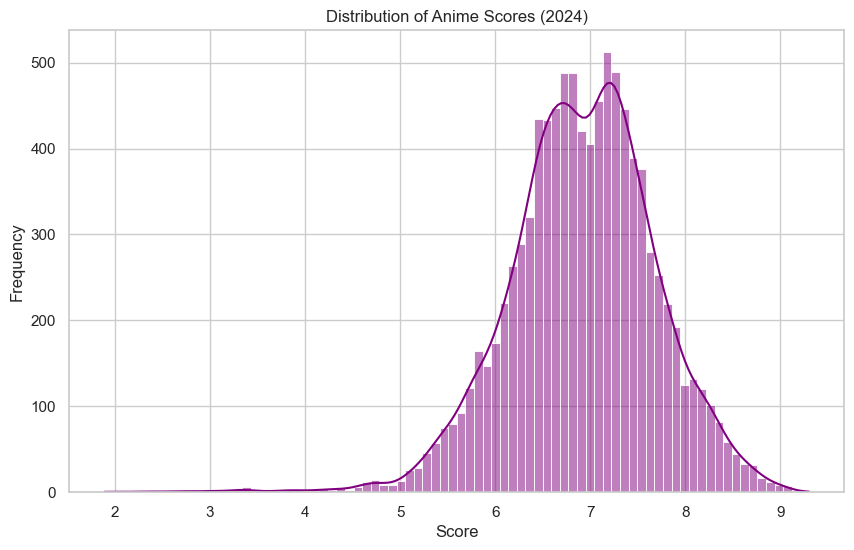

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['score'], kde=True, color='purple')
plt.title('Distribution of Anime Scores (2024)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

Our score feature shows a normal symmetrical distribution around 7, which is a good sign how model will perform well.

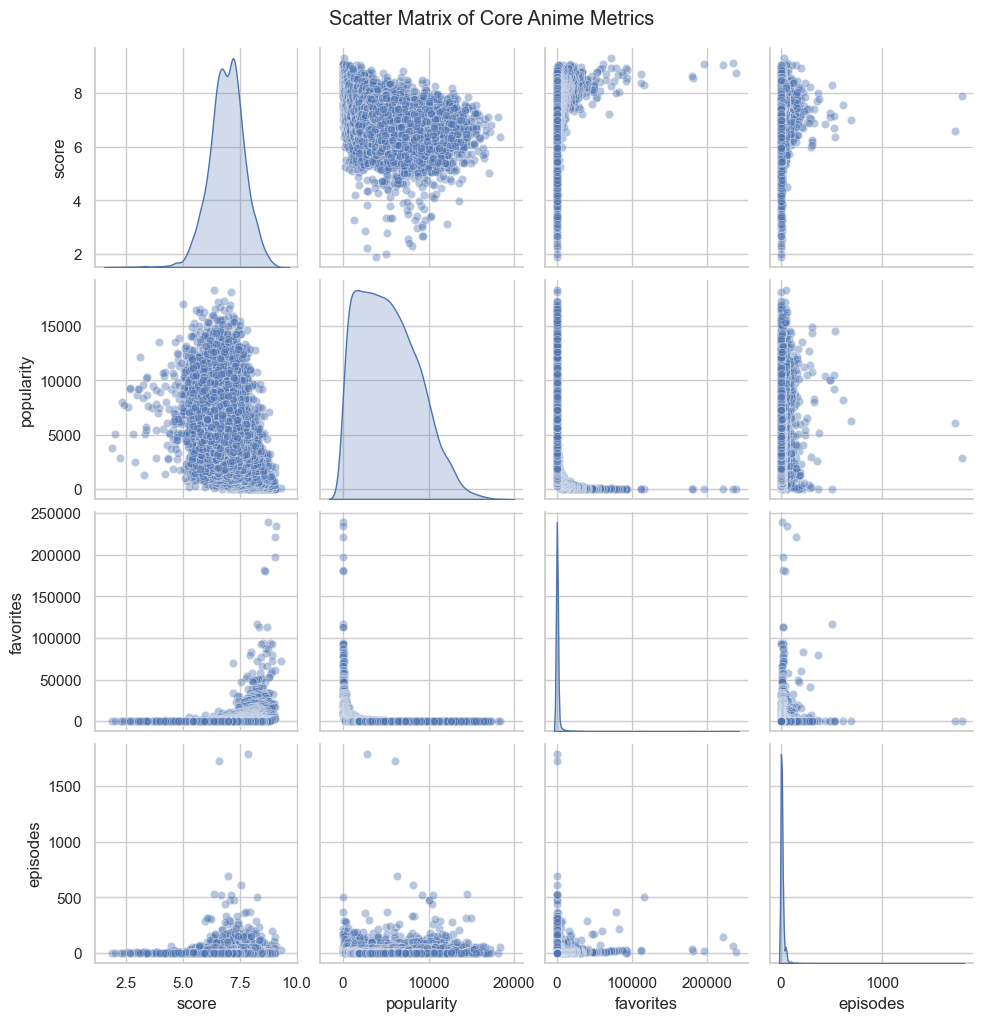

In [22]:
# Select a subset of metrics to avoid crashing the notebook with 100 columns
metrics = ['score', 'popularity', 'favorites', 'episodes']

sns.pairplot(df_clean[metrics], diag_kind='kde', plot_kws={'alpha': 0.4})
plt.suptitle('Scatter Matrix of Core Anime Metrics', y=1.02)
plt.show()

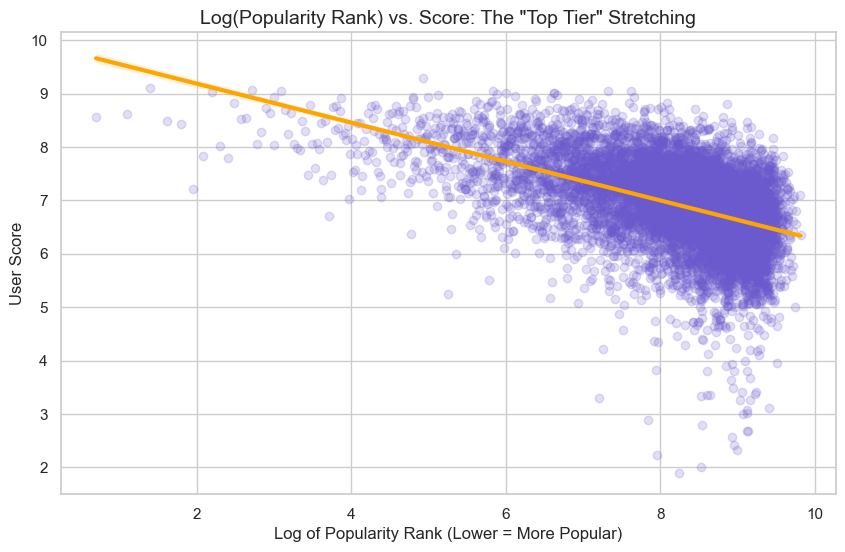

In [23]:
df_clean['log_popularity'] = np.log1p(df_clean['popularity'])

plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_clean, 
    x='log_popularity', 
    y='score',
    scatter_kws={'alpha': 0.2, 'color': 'slateblue'},
    line_kws={'color': 'orange', 'lw': 3},
)

plt.title('Log(Popularity Rank) vs. Score: The "Top Tier" Stretching', fontsize=14)
plt.xlabel('Log of Popularity Rank (Lower = More Popular)')
plt.ylabel('User Score')
plt.show()

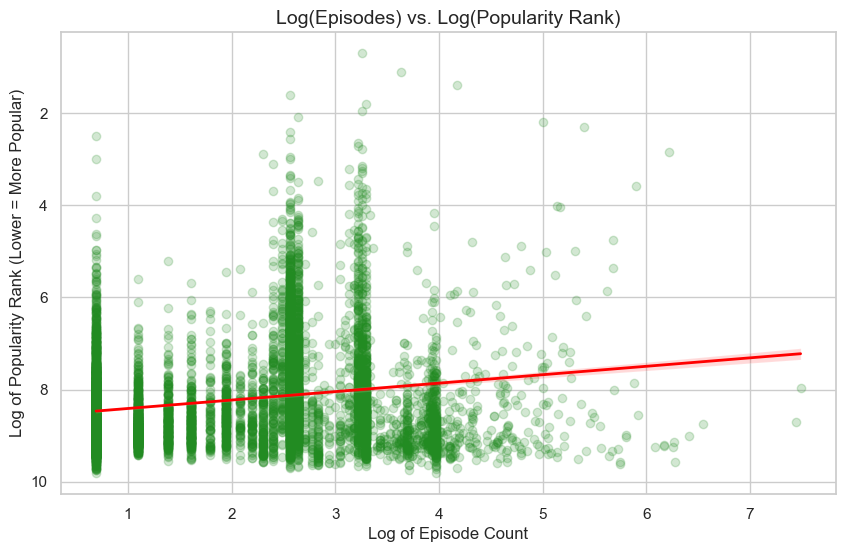

In [24]:
df_clean['log_episodes'] = np.log1p(df_clean['episodes'])

plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_clean, 
    x='log_episodes', 
    y='log_popularity',
    scatter_kws={'alpha': 0.2, 'color': 'forestgreen'},
    line_kws={'color': 'red', 'lw': 2}
)

plt.title('Log(Episodes) vs. Log(Popularity Rank)', fontsize=14)
plt.xlabel('Log of Episode Count')
plt.ylabel('Log of Popularity Rank (Lower = More Popular)')
plt.gca().invert_yaxis() 
plt.show()

The more episodes an anime has the more popularity it attracts and we already know that higher popularity/rank means higher scores.

## Looking for relationshipt between anime genre and score

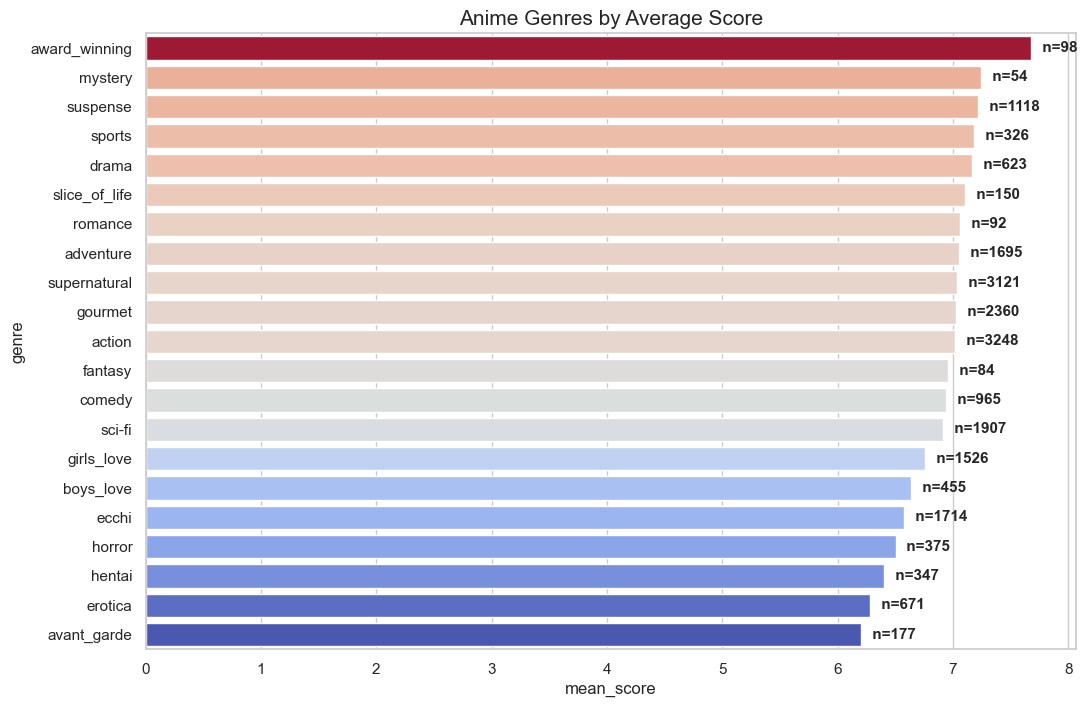

In [25]:
basic_columns = ['title_english', 'status', 'episodes', 'rating', 'rank', 
             'popularity', 'favorites', 'score', 'scored_by_members', 'award winning'] # award winning not a genre
genre_columns = [col for col in df_clean.columns if col not in basic_columns and not col.startswith('theme_')]

genres= []

for genre in genre_columns:
    subset = df_clean[df_clean[genre] == 1]
    
    if len(subset) > 0:
        genres.append({
            'genre': genre,
            'mean_score': subset['score'].mean(),
            'count': len(subset)
        })

genre_df = pd.DataFrame(genres).sort_values('mean_score', ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data = genre_df, 
    x = 'mean_score', 
    y = 'genre', 
    hue = 'mean_score',
    palette ='coolwarm',
    legend = False,
)

for i, p in enumerate(ax.patches):
    count = genre_df.iloc[i]['count']
    
    x_pos = p.get_width()
    y_pos = p.get_y() + p.get_height() / 2
    
    ax.annotate(f' n={int(count)}',   (x_pos, y_pos), va='center',   fontsize=11, fontweight='bold', xytext=(5, 0), textcoords='offset points')
    
plt.title('Anime Genres by Average Score', fontsize=15)
plt.show()

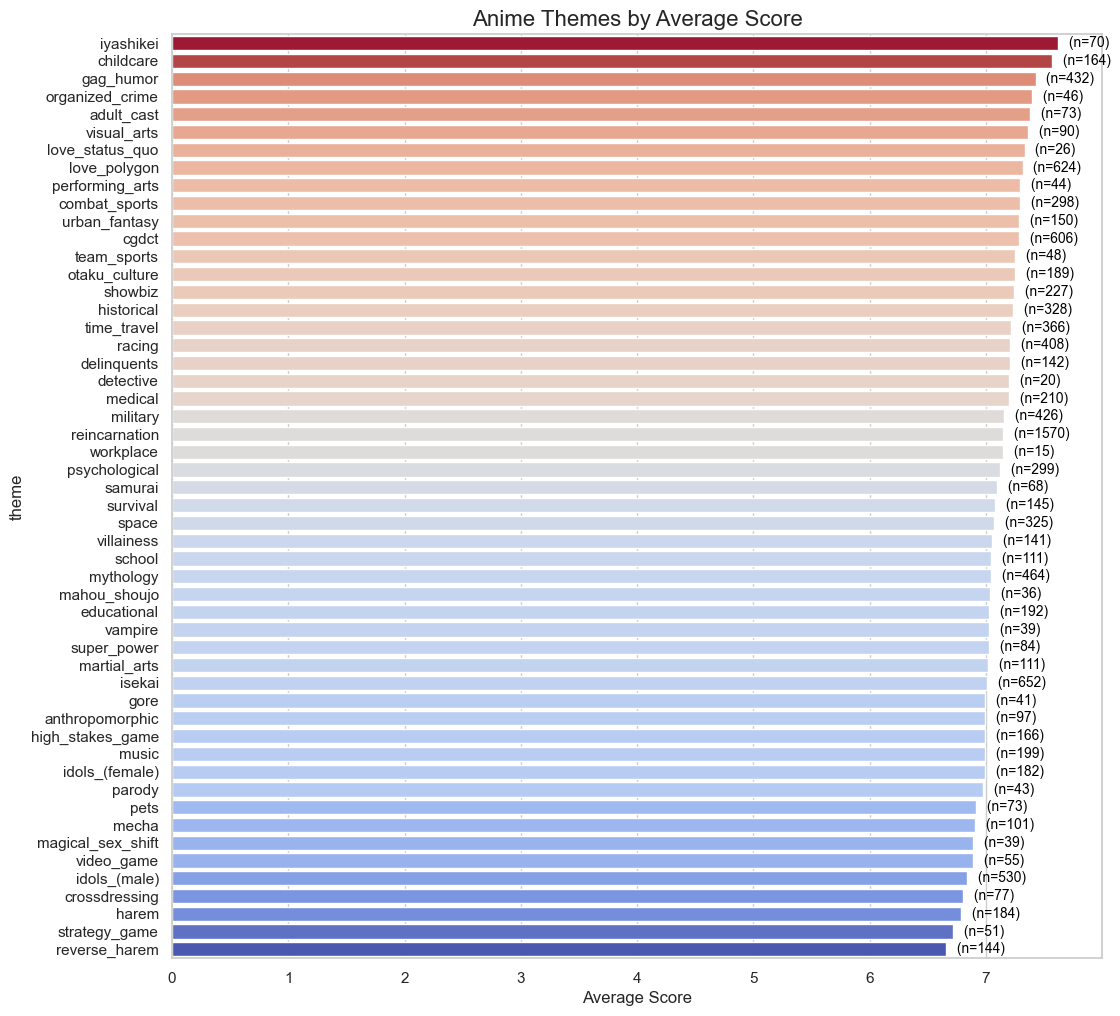

In [26]:
theme_cols = [col for col in df_clean.columns if col.startswith('theme_')]

theme_performance = []

for theme in theme_cols:
    subset = df_clean[df_clean[theme] == 1]
    theme_performance.append({
        'theme': theme.replace('theme_', ''),
        'mean_score': subset['score'].mean(),
        'count': len(subset)
    })

theme_df = pd.DataFrame(theme_performance).sort_values('mean_score', ascending=False)

plt.figure(figsize=(12, 12))
ax = sns.barplot(
    data=theme_df,
    x='mean_score',
    y='theme', 
    hue='mean_score',
    palette='coolwarm',
    legend = False,
)

for i, p in enumerate(ax.patches):
    count = theme_df.iloc[i]['count']
    ax.annotate(f' (n={int(count)})', (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), textcoords='offset points')

plt.title('Anime Themes by Average Score', fontsize=16)
plt.xlabel('Average Score')
plt.show()

Relationshipt between popularity and rating

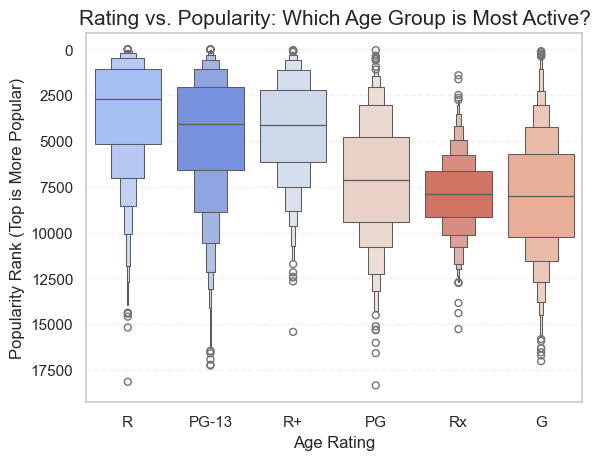

In [27]:
rating_order = df_clean.groupby('rating')['popularity'].median().sort_values().index

sns.boxenplot(
    data=df_clean, 
    x = 'rating', 
    y = 'popularity', 
    order = rating_order,
    legend = False,
    hue = 'rating',
    palette = 'coolwarm'
)

plt.gca().invert_yaxis()

plt.title('Rating vs. Popularity: Which Age Group is Most Active?', fontsize=15)
plt.ylabel('Popularity Rank (Top is More Popular)')
plt.xlabel('Age Rating')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

Look for correlation between the top genres, themes, ratings and user socre

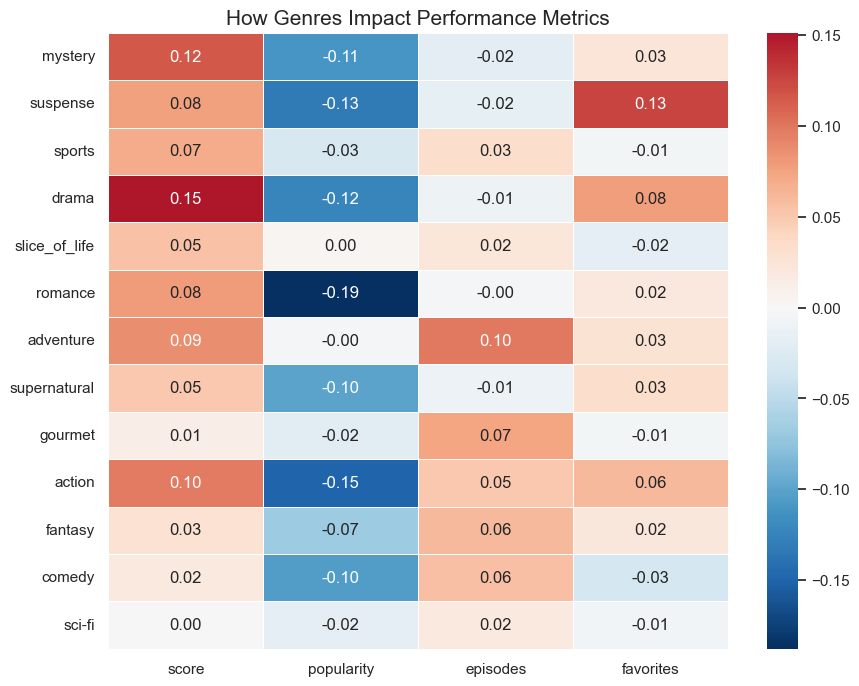

In [28]:
top_genres = [
    'mystery', 'suspense', 'sports', 'drama', 'slice_of_life', 
    'romance', 'adventure', 'supernatural', 'gourmet', 'action', 
    'fantasy', 'comedy', 'sci-fi'
]
top_themes = [
    'theme_iyashikei', 'theme_childcare', 'theme_gag_humor', 'theme_organized_crime', 
    'theme_adult_cast', 'theme_visual_arts', 'theme_love_status_quo', 'theme_love_polygon', 
    'theme_performing_arts', 'theme_combat_sports', 'theme_urban_fantasy', 'theme_cgdct', 
    'theme_team_sports', 'theme_otaku_culture', 'theme_showbiz', 'theme_historical', 
    'theme_time_travel', 'theme_racing', 'theme_delinquents', 'theme_detective', 
    'theme_medical', 'theme_military', 'theme_samurai', 'theme_school'
]
metrics = ['score', 'popularity', 'episodes', 'favorites']

genre_corr = df_clean[top_genres + metrics].corr().loc[top_genres, metrics]

plt.figure(figsize=(10, 8))
sns.heatmap(genre_corr, annot=True, cmap='RdBu_r', center=0, fmt='.2f', linewidths=0.5)
plt.title('How Genres Impact Performance Metrics', fontsize=15)
plt.show()

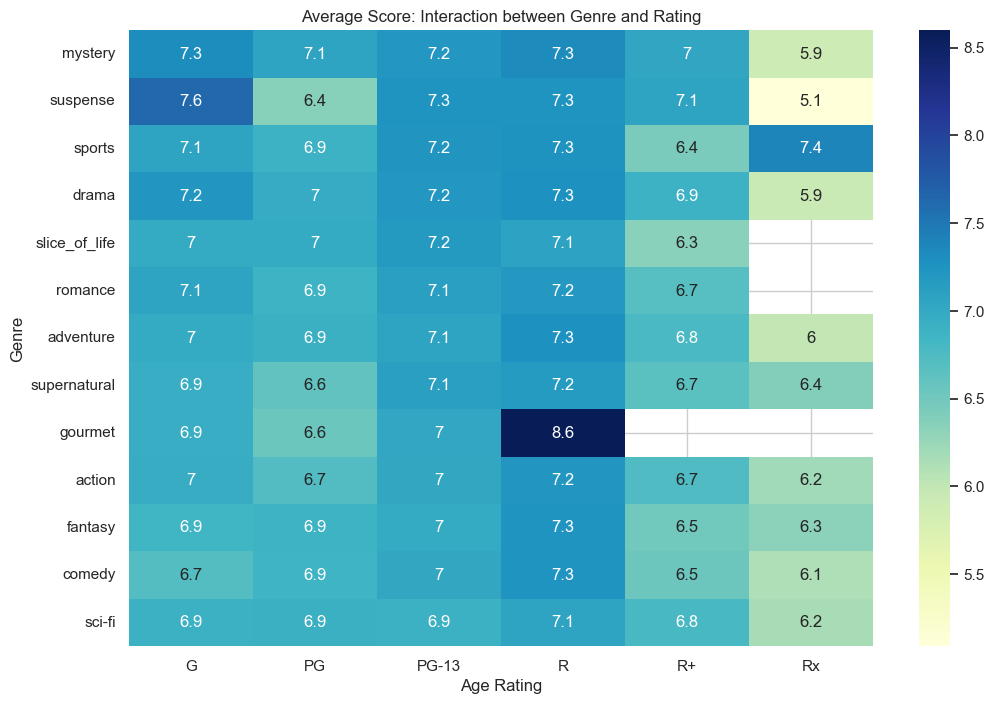

In [29]:
interaction_data = []

for genre in top_genres:
    res = df_clean[df_clean[genre] == 1].groupby('rating')['score'].mean()
    res.name = genre
    interaction_data.append(res)

pivot_df = pd.concat(interaction_data, axis=1).T

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu')
plt.title('Average Score: Interaction between Genre and Rating')
plt.ylabel('Genre')
plt.xlabel('Age Rating')
plt.show()

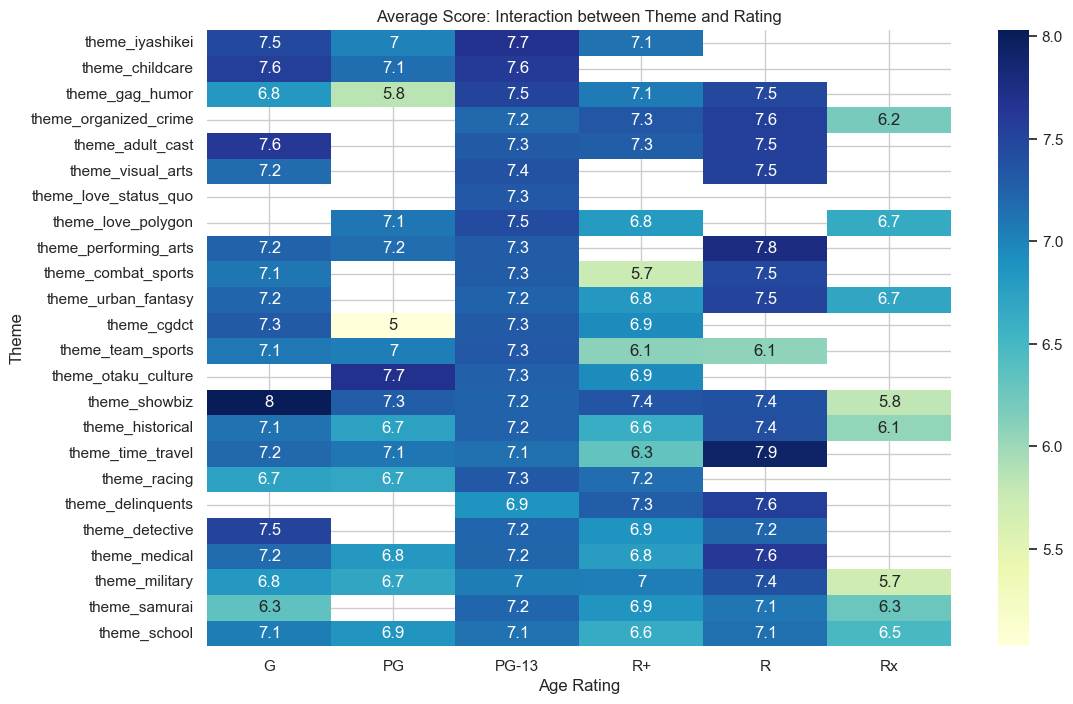

In [30]:
interaction_data = []

for theme in top_themes:
    res = df_clean[df_clean[theme] == 1].groupby('rating')['score'].mean()
    res.name = theme
    interaction_data.append(res)

pivot_df = pd.concat(interaction_data, axis=1).T

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu')
plt.title('Average Score: Interaction between Theme and Rating')
plt.ylabel('Theme')
plt.xlabel('Age Rating')
plt.show()

In [31]:
df_clean.to_csv('anime_data_eda.csv', index=False)

print("File successfully saved as 'anime_data_eda.csv'")

File successfully saved as 'anime_data_eda.csv'


## Итог EDA 

1. Валидация целевой переменной (Score — Оценка)
Результат: Распределение оценок практически идеально симметрично в диапазоне от 4.5 до 9.5.

Значение для ML: Такое «нормальное распределение» подтверждает, что целевая переменная стабильна. Она отлично подходит для обучения моделей линейной регрессии или Random Forest Regressor без необходимости сложного масштабирования.

2. Петля «Популярность — Качество»
Результат: Выявлена сильная положительная корреляция между рейтингом популярности (Popularity Rank), количеством добавлений в избранное (Favorites) и оценкой (Score).

Наблюдение: Высокооцененные шоу закономерно становятся более популярными. Однако мы определили, что признак «Rank» несет в себе риск утечки данных (Data Leakage) — это скорее следствие успеха, а не его причина.

3. Парадокс долголетия (Эпизоды vs Результативность)
Результат: Большое количество эпизодов коррелирует с более высокой популярностью и наличием «порога качества».

Наблюдение: Мы обнаружили L-образное распределение. Короткие сериалы (12–24 серий) сильно различаются по качеству, в то время как очень длинные тайтлы (100+ серий) почти всегда имеют высокие баллы и популярность из-за «ошибки выжившего» (Survivor Bias).

4. Категориальные фавориты (Жанры и Темы)
Результат: Определенные жанры (например, Драма, Саспенс) и темы (например, Исторический, Психологическое) стабильно показывают лучшие результаты, чем остальные.

Значимость: Мы отфильтровали их по размеру выборки (n), чтобы не попасть в ловушку «хитов-однодневок». Темы вроде Иясикэй (Iyashikei) продемонстрировали узкую нишу, но очень высокий уровень удовлетворенности сообщества.

5. Эффекты взаимодействия (Жанр + Возрастной рейтинг)
Результат: «Эффект взросления». Мы обнаружили, что один и тот же жанр (например, Драма) часто получает более высокий средний балл при возрастном рейтинге R-17+ по сравнению с рейтингами G или PG.

6. Фактор «Нишевого шедевра» против «Мейнстрима»
Результат: Скрестив Темы и Рейтинги с Оценкой, мы выяснили, что определенные комбинации с высокой степенью «взрослости» (например, Психологические темы + рейтинг R-17+) приносят самые высокие средние баллы.

Наблюдение: Напротив, темы с рейтингом «G» (например, Детское или Гэг-юмор) показывают более низкий средний балл, но охватывают огромный объем контента. Это подчеркивает четкое разделение между «любимцами критиков» и «массовыми развлечениями».